In [52]:

import torch
import torchvision


# partition MNIST

# we set this to be smaler than the number of model parameters to make it overparametrized

bs = 64
num_training_examples = 20_000

batch_gd_train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(
torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), range(0, num_training_examples)), batch_size = bs, shuffle=True)
batch_size_test = 1000
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_test, shuffle=True)


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [53]:
print("Number of training samples:", len(batch_gd_train_loader.dataset))
print("Number of testing samples:", len(test_loader.dataset))

Number of training samples: 20000
Number of testing samples: 10000


In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net()

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print("Total number of parameters:", get_n_params(network))

Total number of parameters: 21840


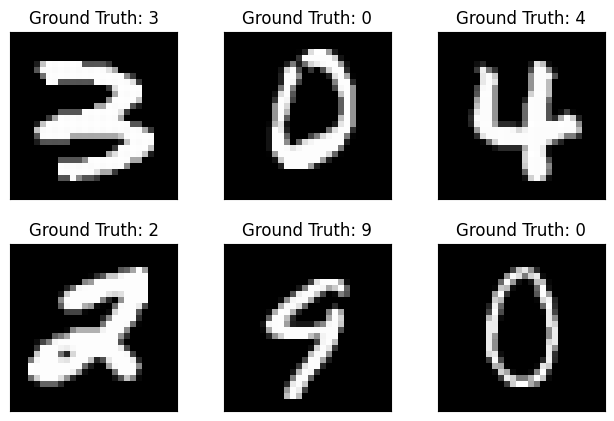

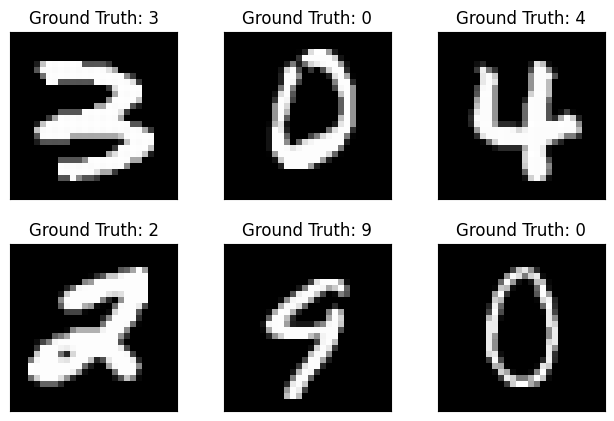

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [56]:
learning_rate = 0.01
# while we use SGD for all our examples, technically it is a function of the data loader's batch size. So since our batch size is the size of the dataset, this is identical to gradient descent
# optimizer = optim.SGD(network.parameters(), lr=learning_rate)
momentum = 0.5
optimizer = optim.SGD(network.parameters(), lr=learning_rate,  momentum=momentum)

In [57]:
#test stats

n_epochs = 5
log_interval = 10

train_losses = []
train_counter = []
train_times = []
test_losses = []
test_counter = [i*len(batch_gd_train_loader.dataset) for i in range(n_epochs + 1)]


def train(epoch):
  
  network.train()
  for batch_idx, (data, target) in enumerate(batch_gd_train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(batch_gd_train_loader.dataset),
        100. * batch_idx / len(batch_gd_train_loader), loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(batch_gd_train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [58]:
from time import time
test()
start = time()
train_times.append(0)
for epoch in range(1, n_epochs + 1):
  train(epoch)
  train_times.append(time() - start)
  test()

/tmp/ipykernel_29675/3265718274.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3132, Accuracy: 885/10000 (9%)

Train Epoch: 1 [0/20000 (0%)]	Loss: 2.340790
Train Epoch: 1 [640/20000 (3%)]	Loss: 2.296706
Train Epoch: 1 [1280/20000 (6%)]	Loss: 2.278047
Train Epoch: 1 [1920/20000 (10%)]	Loss: 2.272770
Train Epoch: 1 [2560/20000 (13%)]	Loss: 2.259359
Train Epoch: 1 [3200/20000 (16%)]	Loss: 2.214737
Train Epoch: 1 [3840/20000 (19%)]	Loss: 2.172050
Train Epoch: 1 [4480/20000 (22%)]	Loss: 2.167688
Train Epoch: 1 [5120/20000 (26%)]	Loss: 2.114728
Train Epoch: 1 [5760/20000 (29%)]	Loss: 2.043475
Train Epoch: 1 [6400/20000 (32%)]	Loss: 1.920386
Train Epoch: 1 [7040/20000 (35%)]	Loss: 1.871319
Train Epoch: 1 [7680/20000 (38%)]	Loss: 1.777129
Train Epoch: 1 [8320/20000 (42%)]	Loss: 1.742689
Train Epoch: 1 [8960/20000 (45%)]	Loss: 1.476835
Train Epoch: 1 [9600/20000 (48%)]	Loss: 1.579929
Train Epoch: 1 [10240/20000 (51%)]	Loss: 1.534174
Train Epoch: 1 [10880/20000 (54%)]	Loss: 1.306177
Train Epoch: 1 [11520/20000 (58%)]	Loss: 1.200428
Train Epoch: 1 [1

Text(0, 0.5, 'negative log likelihood loss')

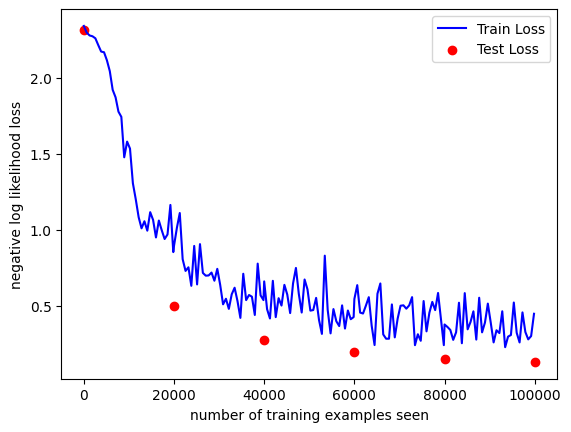

In [59]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Text(0, 0.5, 'Negative Log Likelihood Loss')

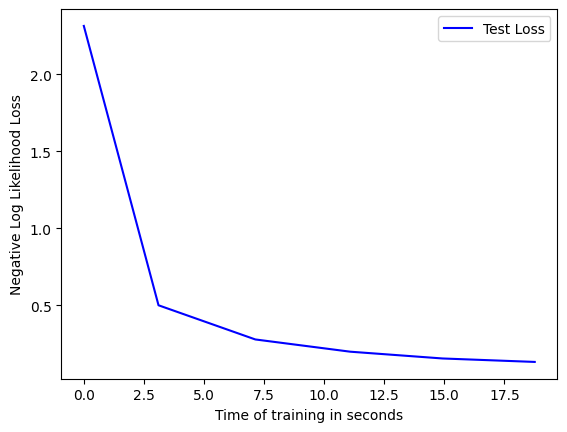

In [60]:
fig = plt.figure()
plt.plot(train_times, test_losses, color='blue')
plt.legend(['Test Loss'], loc='upper right')
plt.xlabel('Time of training in seconds')
plt.ylabel('Negative Log Likelihood Loss')